<a id=top-page></a>
# `pykitPIV` demo: Generate a temporal sequence of images

<div class="alert alert-block alert-info" style="margin-top: 20px">
<font size="3"><strong>Table of contents:</strong></font>
<br>
<ol>
    <li><a href="#generate-particles">Generate particles</a></li>
    <li><a href="#generate-velocity-field">Generate random velocity field to advect the particles</a></li>
    <li><a href="#add-movement">Add movement to particles</a></li>
        <ul>
        <li><a href="#add-movement-update-time-sep">Update time separation</a></li>
        <li><a href="#add-movement-visualize">Visualize the PIV image pair</a></li>
        </ul>
    <li><a href="#save">Save the dataset</a></li>
    <li><a href="#upload">Upload the saved datasets</a></li>
</ol>
<p></p>
</div>
<br>

***

In [1]:
import numpy as np
import cmcrameri.cm as cmc
import matplotlib.animation as animation
import matplotlib.pyplot as plt
from pykitPIV import Particle, FlowField, Motion, Image

In [7]:
save_images = False
n_images = 1
image_size = (512, 512)
size_buffer = 50
origin = 'lower'
figsize = (6,6)
time_separation = 0.2
filename = None

<a id=generate-particles></a>
***

## Generate particles

[Go to the top](#top-page)

Particles added to the image.
Reflected light added to images I1.


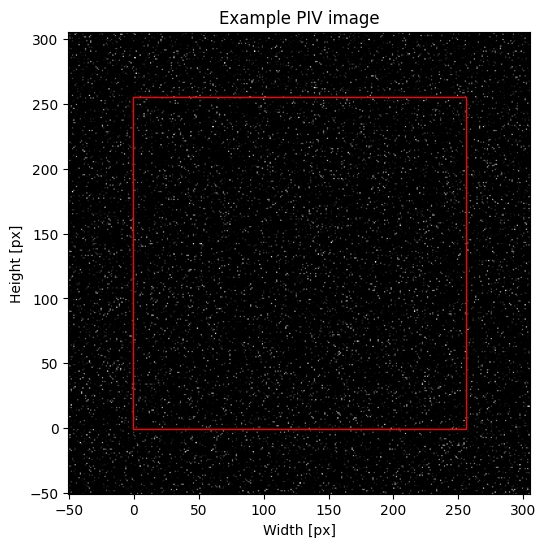

In [3]:
particles = Particle(n_images, 
                     size=image_size, 
                     size_buffer=size_buffer,
                     diameters=(2,3),
                     densities=(0.3,0.36),
                     diameter_std=0,
                     seeding_mode='random', 
                     random_seed=100)

image = Image(random_seed=100)

image.add_particles(particles)

image.add_reflected_light(exposures=(0.6,0.65),
                          maximum_intensity=2**16-1,
                          laser_beam_thickness=1,
                          laser_over_exposure=1,
                          laser_beam_shape=0.95,
                          alpha=1/100)

image.plot(0, 
           with_buffer=True,
           xlabel='Width [px]',
           ylabel='Height [px]',
           title='Example PIV image',
           cmap='Greys_r',
           origin=origin,
           figsize=figsize);

<a id=generate-velocity-field></a>
***

## Generate random velocity field to advect the particles

[Go to the top](#top-page)

Velocity field added to the image.


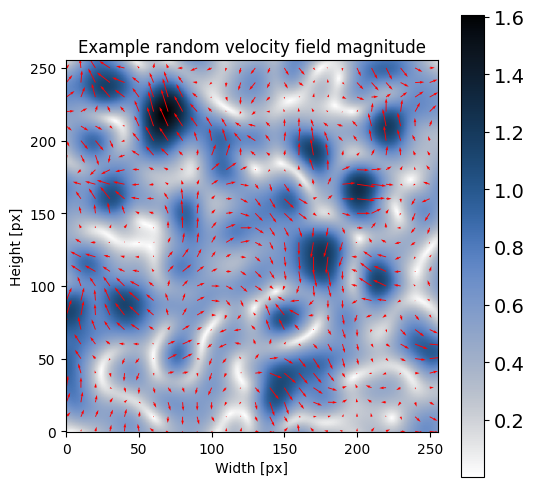

In [4]:
flowfield = FlowField(n_images,
                      size=image_size,
                      size_buffer=size_buffer,
                      random_seed=10)

flowfield.generate_random_velocity_field(gaussian_filters=(2,3),
                                         n_gaussian_filter_iter=20,
                                         displacement=(2,3))

image.add_flowfield(flowfield)

image.plot_field_magnitude(0,
                           with_buffer=False,
                           add_quiver=True,
                           quiver_step=10,
                           quiver_color='r',
                           xlabel='Width [px]',
                           ylabel='Height [px]',
                           title='Example random velocity field magnitude',
                           cmap=cmc.oslo_r,
                           figsize=figsize);

<a id=add-movement></a>
***

## Add movement to particles

[Go to the top](#top-page)

Particle movement added to the image.
Reflected light added to images I1.
Reflected light added to images I2.


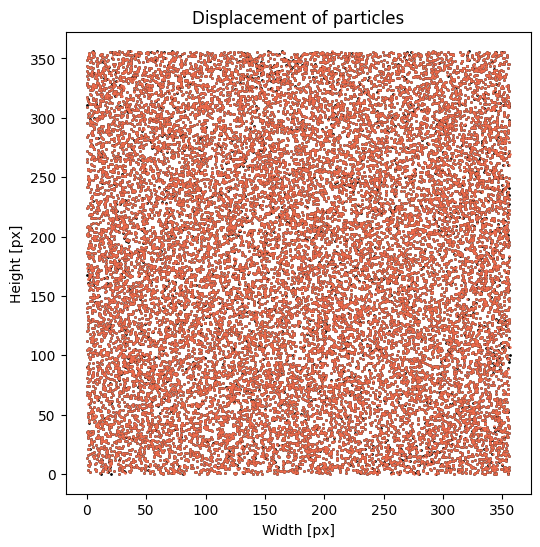

In [5]:
motion = Motion(particles, 
                flowfield, 
                time_separation=time_separation)

motion.forward_euler(n_steps=10)

motion.plot_particle_motion(0,
                            s=1,
                            xlabel='Width [px]',
                            ylabel='Height [px]',
                            title='Displacement of particles',
                            figsize=figsize);

image.add_motion(motion)

image.add_reflected_light(exposures=(0.6,0.6001),
                          maximum_intensity=2**16-1,
                          laser_beam_thickness=1,
                          laser_over_exposure=1,
                          laser_beam_shape=0.95,
                          alpha=1/20)

In [25]:
current_I2 = [image.remove_buffers(image.images_I2)]

for i in range(0,10):

    print('t = ' + str(round((i+2)*time_separation,1)) + 's')

    new_images_I1 = motion.particle_coordinates_I2
    
    particles.upload_particle_coordinates(new_images_I1)
    
    motion = Motion(particles, 
                flowfield, 
                time_separation=time_separation)
    
    motion.runge_kutta_4th(n_steps=4)
    
    image.add_motion(motion)
    image.add_reflected_light(exposures=(0.6,0.6001),
                              maximum_intensity=2**16-1,
                              laser_beam_thickness=1,
                              laser_over_exposure=1,
                              laser_beam_shape=0.95,
                              alpha=1/20)

    current_I2.append(image.remove_buffers(image.images_I2))

t = 0.2s
Particle movement added to the image.
Reflected light added to images I1.
Reflected light added to images I2.
t = 0.3s
Particle movement added to the image.
Reflected light added to images I1.
Reflected light added to images I2.
t = 0.4s
Particle movement added to the image.
Reflected light added to images I1.
Reflected light added to images I2.
t = 0.5s
Particle movement added to the image.
Reflected light added to images I1.
Reflected light added to images I2.
t = 0.6s
Particle movement added to the image.
Reflected light added to images I1.
Reflected light added to images I2.
t = 0.7s
Particle movement added to the image.
Reflected light added to images I1.
Reflected light added to images I2.
t = 0.8s
Particle movement added to the image.
Reflected light added to images I1.
Reflected light added to images I2.
t = 0.9s
Particle movement added to the image.
Reflected light added to images I1.
Reflected light added to images I2.
t = 1.0s
Particle movement added to the image.
R

***

## Animate

In [26]:
def animate_evolution(imagelist):

    fig = plt.figure(figsize=(6,6))

    im = plt.imshow(imagelist[0][0,0,:,:], cmap='Greys_r', origin=origin, animated=True)
    
    def updatefig(j):

        im.set_array(imagelist[j][0,0,:,:])

        return [im]
    
    anim = animation.FuncAnimation(fig, updatefig, frames=range(len(current_I2)), interval=1, blit=True)
    
    anim.save('anim-const-exposure.gif', fps=20, bitrate=-1, dpi=150, savefig_kwargs={'bbox_inches' : 'tight'})
    
    return anim

MovieWriter ffmpeg unavailable; using Pillow instead.


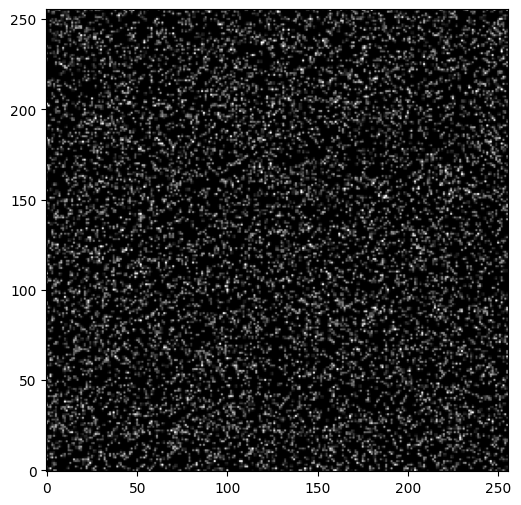

In [27]:
animate_evolution(current_I2)

***

© K. Zdybał, C. Mucignat, I. Lunati (2024)